# Quantitatively, do TMDLs spur limit changes?

Author: Ryan Treves

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import seaborn as sns
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data_path = 'data/'

# Load ATTAINS data
tmdls = pd.read_csv(data_path + 'all_actions.csv', parse_dates=['completionDate', 'TMDLDate'],
                    date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(
    columns={'assessmentUnitIdentifier': 'AUID'})

# Load RAD Data
# HUC AUID link table (source: `get_huc_AUID_links.R`)
HUC_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object})
HUC_AUID_links = HUC_AUID_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.huc12': 'HUC-12', 'attributes.assessmentunitidentifier': 'AUID'})
# HUC NPDES permit link table (source: `get_huc_npdes_permit_links.R`)
HUC_npdes_permit_links = pd.read_csv(data_path + 'huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object})
HUC_npdes_permit_links = HUC_npdes_permit_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(
    columns={'attributes.assessmentunitidentifier': 'AUID', 'attributes.huc12': 'HUC-12'})

In [3]:
# Link TMDLs to HUC-12 codes to NPDES permittees
tmdls_merged = tmdls.drop_duplicates().merge(HUC_AUID_links, on='AUID', how='inner').merge(HUC_npdes_permit_links,
                                                                                           on='HUC-12', how='inner')

# Filter down to point-source TMDLs
tmdls_merged = tmdls_merged[tmdls_merged['pollutantSourceTypeCode'] != 'Nonpoint source']

# Deleting objects we no longer need to save memory
del tmdls
del HUC_AUID_links
del HUC_npdes_permit_links

In [4]:
tmdls_merged.drop_duplicates('actionIdentifier')['pollutantName'].value_counts(normalize=True)

ESCHERICHIA COLI (E. COLI)                                      0.164796
FECAL COLIFORM                                                  0.162596
IRON                                                            0.155116
PHOSPHORUS, TOTAL                                               0.092849
SEDIMENT                                                        0.044884
TOTAL SUSPENDED SOLIDS (TSS)                                    0.034763
PHOSPHORUS                                                      0.033003
NITROGEN, TOTAL                                                 0.029483
ENTEROCOCCUS BACTERIA                                           0.024202
ALUMINUM                                                        0.021562
MANGANESE                                                       0.017602
MERCURY                                                         0.014961
EUTROPHICATION                                                  0.014521
PH                                                 

Our first challenge is to link values of `pollutantName` in the TMDLs table with values of `parameter_desc` in the DMRs table.

In [5]:
# Dictionary linking `pollutantName` from ATTAINS to one or more values of `parameter_desc` from ICIS-NPDES.
# Note: there is definitely some uncertainty involved in this linkage due to my lack of expertise in water chemistry
# (e.g., are there point-source parameters not related to BOD that may still contribute to water body impairment caused by BOD?).
# Copied matching parameters from the list of values of `parameter_desc` in DMR Data dictionary, minus those indicating '% removed'.
# Keys are names of pollutants from the list of all point-source TMDLs.
# This list includes all pollutants that individually represent >1% of all TMDLs, and in total covers ~84% of all TMDLs in ATTAINS
pollutant_parameter_link_dict = {
    'ALUMINUM': ['Aluminum', 'Aluminum [total]', 'Aluminum chloride, dissolved, water', 'Aluminum oxide',
                 'Aluminum stearate, wat sol in drill fl', 'Aluminum sulfate',
                 'Aluminum, acid soluble', 'Aluminum, dissolved [as Al]', 'Aluminum, ion',
                 'Aluminum, potentially dissolvd', 'Aluminum, total',
                 'Aluminum, total [as Al]',
                 'Aluminum, total [as Al] [Can Production]', 'Aluminum, total recoverable',
                 'Aluminum, total sludge, dry wt.'],

    'AMMONIA': ['Ammonia [as N] + unionized ammonia', 'Ammonia & ammonium- total',
                'Ammonia nitrogen, total, [as N] 30 day', 'Ammonia, unionized', 'Nitrogen, ammonia [NH3-N]',
                'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'AMMONIA-NITROGEN': ['Ammonia nitrogen, total, [as N] 30 day', 'Nitrogen, ammonia [NH3-N]',
                         'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                         'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                         'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                         'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                         'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                         'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                         'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'AMMONIA, TOTAL': ['Ammonia [as N] + unionized ammonia', 'Ammonia & ammonium- total',
                       'Ammonia nitrogen, total, [as N] 30 day', 'Ammonia, unionized', 'Nitrogen, ammonia [NH3-N]',
                       'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                       'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                       'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                       'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                       'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                       'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                       'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'ARSENIC': ['Arsenic', 'Arsenic total, dry weight, sludge', 'Arsenic, dissolved [as As]', 'Arsenic, dry weight',
                'Arsenic, Inorganic', 'Arsenic, potentially dissolved', 'Arsenic, sludge tot. dry wt [as As]',
                'Arsenic, total [as As]', 'Arsenic, total recoverable', 'Arsenic, total recoverable',
                'Arsenic, trivalent dissolved', 'Arsenic, trivalent total', 'Arsenic, trivalent total recoverable'],

    'BIOCHEMICAL OXYGEN DEMAND (BOD)': ['Non-nitrogenous BOD', 'Carbonaceous BOD, 5 day, 20 deg C filtrd', 'BOD',
                                        'BOD 5-Day [lbs/1000 lbs Product]', 'BOD excursions', 'BOD, [ult. 1st stage]',
                                        'BOD, [ult. 2nd stage]', 'BOD, [ult. all stages]', 'BOD, % over influent',
                                        'BOD, 11-day [20 deg. C]', 'BOD, 120 Day,20 Degrees C',
                                        'BOD, 20-day [20 deg. C]', 'BOD, 20-day, percent removal',
                                        'BOD, 35-day [20 deg. C]', 'BOD, 5 day carbonaceous, % rmvl, dry',
                                        'BOD, 5 day carbonaceous, % rmvl, wet', 'BOD, 5 day percent removal, dry',
                                        'BOD, 5 day percent removal, wet', 'BOD, 5 lb/cu ft process', 'BOD, 5-day',
                                        'BOD, 5-day, 20 deg C per cfs of streamflw', 'BOD, 5-day, 20 deg. C',
                                        'BOD, 5-day, 20 deg. C', 'BOD, 5-day, 20 deg. C',
                                        'BOD, 5-day, 20 deg. C [per season]', 'BOD, 5-day, 20 deg. C per production',
                                        'BOD, 5-day, dissolved', 'BOD, 5-day, percent removal', 'BOD, 5-day, total',
                                        'BOD, carb-5 day, 20 deg C, percent removal',
                                        'BOD, carbonaceous [20 day, 20 C]', 'BOD, carbonaceous [25-day, 20 C]',
                                        'BOD, carbonaceous [28 day, 20 C]', 'BOD, carbonaceous [40 day, 20 C]',
                                        'BOD, carbonaceous [5 day, 20 C]', 'BOD, carbonaceous [5 day, 20 C][load]',
                                        'BOD, carbonaceous [5 day, 20 C][per discharge]',
                                        'BOD, carbonaceous [5 day, 5 C]', 'BOD, carbonaceous [5-day, 20 C][streamflow]',
                                        'BOD, carbonaceous, 20-day, % Removal', 'BOD, carbonaceous, percent removal',
                                        'BOD, filtered, 5 day, 20 deg C', 'BOD, mass, times flow prop. multiplier',
                                        'BOD, nitrogen inhib 5-day [20 deg. C]', 'Avg. of 7-day sum of BOD5 values'],

    'CADMIUM': ['Cadmium', 'Cadmium [Cd], in barite, dry weight', 'Cadmium, dissolved [as Cd]', 'Cadmium, dry weight',
                'Cadmium, in bottom deposits [dry wgt]', 'Cadmium, percent removal', 'Cadmium, potentially dissolvd',
                'Cadmium, sludge solid', 'Cadmium, sludge total', 'Cadmium, sludge, total, dry weight [as Cd]',
                'Cadmium, total [as Cd]', 'Cadmium, total [as Cd] [per discharge]', 'Cadmium, total recoverable'],

    'CARBONACEOUS BOD': ['BOD, carbonaceous [20 day, 20 C]', 'BOD, carbonaceous [25-day, 20 C]',
                         'BOD, carbonaceous [28 day, 20 C]', 'BOD, carbonaceous [40 day, 20 C]',
                         'BOD, carbonaceous [5 day, 20 C]', 'BOD, carbonaceous [5 day, 20 C][load]',
                         'BOD, carbonaceous [5 day, 20 C][per discharge]', 'BOD, carbonaceous [5 day, 5 C]',
                         'BOD, carbonaceous [5-day, 20 C][streamflow]', 'Carbonaceous BOD, 5 day, 20 deg C filtrd'],

    'CHLORDANE': ['Chlordane', 'Chlordane - Nonachlor, Cis', 'Chlordane - Nonachlor, Trans',
                  'Chlordane [tech mix & metabs], dry wgt', 'Chlordane [tech mix. and metabolites]',
                  'Chlordane, .alpha.-, dry weight', 'Chlordane, .alpha.-, whole water',
                  'Chlordane, CA Ocean Plan definition'],

    'CHROMIUM, TOTAL': ['Chromium', 'Chromium hexavalent [as Cr]', 'Chromium III', 'Chromium, dissolved [as Cr]',
                        'Chromium, hexavalent', 'Chromium, hexavalent', 'Chromium, hexavalent [as Cr]',
                        'Chromium, hexavalent dissolved [as Cr]', 'Chromium, hexavalent in bot dep [dry wt]',
                        'Chromium, hexavalent potentially disolvd', 'Chromium, hexavalent tot recoverable',
                        'Chromium, hexavalent tot recoverable', 'Chromium, sludge solid', 'Chromium, sludge total',
                        'Chromium, sludge, total, dry weight [as Cr]', 'Chromium, suspended [as Cr]', 'Chromium, total',
                        'Chromium, total [as Cr]', 'Chromium, total [as Cr]',
                        'Chromium, total [as Cr] [Can Production]', 'Chromium, total [as Cr] [per discharge]',
                        'Chromium, total dry weight [as Cr]', 'Chromium, total in bot dep [wet wgt]',
                        'Chromium, total recoverable', 'Chromium, trivalent [as Cr]',
                        'Chromium, trivalent dissolved, as Cr', 'Chromium, trivalent in bottom deposits',
                        'Chromium, trivalent total recoverable', 'Chromium, trivalent, potentially dissolvd'],

    'COPPER': ['Copper', 'Copper as suspended black oxide', 'Copper in bottom deposits [dry wgt]',
               'Copper, calculated limit', 'Copper, dissolved [as Cu]', 'Copper, dry weight', 'Copper, percent removal',
               'Copper, potentially dissolved', 'Copper, sludge solid', 'Copper, sludge total',
               'Copper, sludge, total, dry weight [as Cu]', 'Copper, suspended [as Cu]', 'Copper, total [as Cu]',
               'Copper, total [as Cu] [per discharge]', 'Copper, total per batch', 'Copper, total recoverable',
               'Copper, total recoverable'],

    'CYANIDE': ['Cyanide', 'Cyanide [A]', 'Cyanide and thiocyanate - total', 'Cyanide complexed to range of compound',
                'Cyanide in bottom deposits [dry wgt]', 'Cyanide, dissolved std method', 'Cyanide, filterable, total',
                'Cyanide, free [amen. to chlorination]', 'Cyanide, free [amenable to chlorine]',
                'Cyanide, free available', 'Cyanide, free not amenable to chlorin.',
                'Cyanide, free-water plus wastewaters', 'Cyanide, sludge solid', 'Cyanide, total [as CN]',
                'Cyanide, total recoverable', 'Cyanide, weak acid, dissociable'],

    'DISSOLVED OXYGEN': ['Oxygen, dissolved [DO]', 'Oxygen, dissolved [DO] minimum',
                         'Oxygen, dissolved percent saturation', 'Oxygen, dissolved, % of time violated'],

    'ENTEROCOCCUS BACTERIA': ['Enterococci Enterococci - % of upper confidence limit',
                              'Enterococci - % samples exceeding limit', 'Enterococci: group D, MF trans, M-E, EIA'],

    'ESCHERICHIA COLI (E. COLI)': ['E. coli', 'E. coli exceedances', 'E. coli, colony forming units [CFU]',
                                   'E. coli, MTEC-MF', 'E. coli, thermotol, MF, MTEC'],

    # Here I just included all Nitrogen, Ammonia, and Phosphorus parameters
    'EUTROPHICATION': ['Nitrogen [as NO3] sludge solid', 'Nitrogen Kjeldahl, total [TKN]', 'Nitrogen oxides [as N]',
                       'Nitrogen sludge solid', 'Nitrogen sludge total', 'Nitrogen-nitrate in water, [pct]',
                       'Nitrogen-nitrite in water, [pct]', 'Nitrogen, ammonia [NH3-N]',
                       'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                       'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                       'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                       'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                       'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                       'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                       'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal', 'Nitrogen, Dissolved',
                       'Nitrogen, inorganic total', 'Nitrogen, Kjeldahl', 'Nitrogen, Kjeldahl, dissolved [as N]',
                       'Nitrogen, Kjeldahl, total [as N]', 'Nitrogen, Kjeldahl, total [as N] [per discharge]',
                       'Nitrogen, Kjeldahl, total [TKN] [water]', 'Nitrogen, Kjeldahl, total [TKN], [sludge]',
                       'Nitrogen, Kjeldahl,Total[TKN], insoluble', 'Nitrogen, KjeldahlTotal',
                       'Nitrogen, nitrate [NO3], [sludge]', 'Nitrogen, nitrate [NO3], [water]',
                       'Nitrogen, nitrate dissolved', 'Nitrogen, nitrate total [as N]',
                       'Nitrogen, nitrate total [as NO3]', 'Nitrogen, NitrateTotal', 'Nitrogen, nitrite total [as N]',
                       'Nitrogen, nitrite total [as NO2]', 'Nitrogen, NitriteTotal', 'Nitrogen, organic total [as N]',
                       'Nitrogen, organic, dissolved [as N]', 'Nitrogen, oxidized',
                       'Nitrogen, sludge, total, dry weight [as N]', 'Nitrogen, Total', 'Nitrogen, total',
                       'Nitrogen, total [as N]', 'Nitrogen, total [as N]', 'Nitrogen, total [as N] [adjusted]',
                       'Nitrogen, total [as N] [credit]', 'Nitrogen, total [as N] [delivered]', 'Nitrogen, Total As N',
                       'Nitrogen, Total as NO3 + NH3', 'Nitrogen, total available [water]',
                       'Nitrogen, total available, [sludge]', 'Nitrogen, total Kjeldahl',
                       'Nitrogen, total Kjeldahl, % removal', 'Nitrogen, total, as NO3, [sludge]',
                       'Nitrogen, total, as NO3, [water]', 'Phosphorous 32, total',
                       'Phosphorous, in total orthophosphate', 'Phosphorous, total elemental',
                       'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable',
                       'Phosphorous, total, in bottom deposits', 'Phosphorus [reactive as P]', 'Phosphorus Adsorption',
                       'Phosphorus Pentoxide', 'Phosphorus, brays', 'Phosphorus, dissolved',
                       'Phosphorus, dissolved reactive [drp as P]', 'Phosphorus, insoluble', 'Phosphorus, ortho',
                       'Phosphorus, sludge, total, dry weight [as P]', 'Phosphorus, Total', 'Phosphorus, total [as P]',
                       'Phosphorus, total [as P] [Can Production]', 'Phosphorus, total [as P] [credit]',
                       'Phosphorus, total [as P] [delivered]', 'Phosphorus, total [as P] [per season]',
                       'Phosphorus, Total [Avg Seasonal Load Cap]', 'Phosphorus, Total As P',
                       'Phosphorus, total percent removal', 'Phosphorus, total soluble [as PO4]',
                       'Ammonia [as N] + unionized ammonia', 'Ammonia & ammonium- total',
                       'Ammonia nitrogen, total, [as N] 30 day', 'Ammonia, unionized', 'Nitrogen, ammonia [NH3-N]',
                       'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                       'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                       'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                       'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                       'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                       'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                       'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'FECAL COLIFORM': ['Fecal coliform', 'Fecal coliform in sludge, CFU/gram', 'Fecal coliform, MPN, EC med, 44.5 C'],

    'IRON': ['Iron', 'Iron [total]', 'Iron and manganese, soluble', 'Iron and manganese, total', 'Iron oxide',
             'Iron, dissolved [as Fe]', 'Iron, dissolved from dry deposition', 'Iron, ferrous',
             'Iron, ferrous - present', 'Iron, potentially dissolvd', 'Iron, sludge, total, dry weight [as Fe]',
             'Iron, suspended', 'Iron, total [as Fe]', 'Iron, total [as Fe]', 'Iron, total dry weight [as Fe]',
             'Iron, total per batch', 'Iron, total per production', 'Iron, total recoverable'],

    'LEAD': ['Lead,Lead 210', 'Lead 210, total', 'Lead 212', 'Lead 214', 'Lead-212 [Radioactivity Concentration]',
             'Lead, calculated limit', 'Lead, dissolved [as Pb]', 'Lead, Organic, Total', 'Lead, potentially dissolvd',
             'Lead, sludge solid', 'Lead, sludge total', 'Lead, sludge, total, dry weight [as Pb]',
             'Lead, total [as Pb]', 'Lead, total [as Pb] [per discharge]', 'Lead, total dry weight [as Pb]',
             'Lead, total recoverable', 'Lead, total recoverable', 'Lead, total sludge'],

    'MANGANESE': ['Manganese [total]', 'Manganese in bottom deposits [dry wgt]', 'Manganese oxide',
                  'Manganese, dissolved [as Mn]', 'Manganese, potentially dissolvd', 'Manganese, suspended',
                  'Manganese, total', 'Manganese, total [as Mn]', 'Manganese, total [as Mn] [Can Production]',
                  'Manganese, total recoverable', 'Iron and manganese, soluble', 'Iron and manganese, total'],

    'MERCURY': ['Mercury', 'Mercury [Hg], in barite, dry weight', 'Mercury, dissolved [as Hg]',
                'Mercury, potentially dissolvd', 'Mercury, sludge, total, dry weight [as Hg]',
                'Mercury, tot in bot deposits [dry wgt]', 'Mercury, total [as Hg]',
                'Mercury, total [as Hg] [per discharge]', 'Mercury, total [low level]', 'Mercury, total low level',
                'Mercury, total recoverable', 'Mercury, total recoverable'],

    'NH3-N': ['Ammonia nitrogen, total, [as N] 30 day', 'Nitrogen, ammonia [NH3-N]',
              'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
              'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
              'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
              'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
              'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
              'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
              'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'NICKEL': ['Nickel', 'Nickel carbonyl', 'Nickel, dissolved [as Ni]', 'Nickel, potentially dissolvd',
               'Nickel, sludge solid', 'Nickel, sludge total', 'Nickel, sludge, total, dry weight [as Ni]',
               'Nickel, suspended [as Ni]', 'Nickel, tot in bottom deposits [dry wgt]', 'Nickel, total [as Ni]',
               'Nickel, total [as Ni] [per discharge]', 'Nickel, total per batch', 'Nickel, total recoverable',
               'Nickel, total sludge'],

    'NITROGEN, NITRATE': ['Nitrogen-nitrate in water, [pct]', 'Nitrogen, inorganic total',
                          'Nitrogen, nitrate [NO3], [water]', 'Nitrogen, Total as NO3 + NH3',
                          'Nitrogen, total, as NO3, [sludge]', 'Nitrogen, total, as NO3, [water]',
                          'Nitrogen, nitrate total [as N]', 'Nitrite + Nitrate total [as N]',
                          'Nitrite + Nitrate total [as N]', 'Nitrite plus nitrate dissolved 1 det.',
                          'Nitrite plus nitrate in bottom deposits', 'Nitrite Plus Nitrate Total',
                          'Nitrite plus Nitrate, dry weight [as N]'],

    'NITROGEN, NITRITE': ['Nitrite + Nitrate total [as N]', 'Nitrite + Nitrate total [as N]',
                          'Nitrite nitrogen, dissolved [as N]', 'Nitrite plus nitrate dissolved 1 det.',
                          'Nitrite plus nitrate in bottom deposits', 'Nitrite Plus Nitrate Total',
                          'Nitrite plus Nitrate, dry weight [as N]', 'Nitrogen-nitrite in water, [pct]',
                          'Nitrogen, nitrite total [as N]', 'Nitrogen, nitrite total [as NO2]',
                          'Nitrogen, NitriteTotal', 'Nitrogen, inorganic total'],

    'NITROGEN, TOTAL': ['Nitrogen [as NO3] sludge solid', 'Nitrogen Kjeldahl, total [TKN]', 'Nitrogen oxides [as N]',
                        'Nitrogen sludge solid', 'Nitrogen sludge total', 'Nitrogen-nitrate in water, [pct]',
                        'Nitrogen-nitrite in water, [pct]', 'Nitrogen, ammonia [NH3-N]',
                        'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                        'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                        'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                        'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                        'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                        'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                        'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal', 'Nitrogen, Dissolved',
                        'Nitrogen, inorganic total', 'Nitrogen, Kjeldahl', 'Nitrogen, Kjeldahl, dissolved [as N]',
                        'Nitrogen, Kjeldahl, total [as N]', 'Nitrogen, Kjeldahl, total [as N] [per discharge]',
                        'Nitrogen, Kjeldahl, total [TKN] [water]', 'Nitrogen, Kjeldahl, total [TKN], [sludge]',
                        'Nitrogen, Kjeldahl,Total[TKN], insoluble', 'Nitrogen, KjeldahlTotal',
                        'Nitrogen, nitrate [NO3], [sludge]', 'Nitrogen, nitrate [NO3], [water]',
                        'Nitrogen, nitrate dissolved', 'Nitrogen, nitrate total [as N]',
                        'Nitrogen, nitrate total [as NO3]', 'Nitrogen, NitrateTotal', 'Nitrogen, nitrite total [as N]',
                        'Nitrogen, nitrite total [as NO2]', 'Nitrogen, NitriteTotal', 'Nitrogen, organic total [as N]',
                        'Nitrogen, organic, dissolved [as N]', 'Nitrogen, oxidized',
                        'Nitrogen, sludge, total, dry weight [as N]', 'Nitrogen, Total', 'Nitrogen, total',
                        'Nitrogen, total [as N]', 'Nitrogen, total [as N]', 'Nitrogen, total [as N] [adjusted]',
                        'Nitrogen, total [as N] [credit]', 'Nitrogen, total [as N] [delivered]', 'Nitrogen, Total As N',
                        'Nitrogen, Total as NO3 + NH3', 'Nitrogen, total available [water]',
                        'Nitrogen, total available, [sludge]', 'Nitrogen, total Kjeldahl',
                        'Nitrogen, total Kjeldahl, % removal', 'Nitrogen, total, as NO3, [sludge]',
                        'Nitrogen, total, as NO3, [water]'],

    'SEDIMENT': ['Sediment sample [dry weight]', 'Sediment, suspended'],

    'SEDIMENTATION/SILTATION': ['Sediment sample [dry weight]', 'Sediment, suspended'],

    'SELENIUM': ['Selenium, acid soluble', 'Selenium, dissolved [as Se]', 'Selenium, dry weight',
                 'Selenium, potentially dissolvd', 'Selenium, sludge solid',
                 'Selenium, sludge, total, dry weight [as Se]', 'Selenium, total [as Se]',
                 'Selenium, total recoverable'],

    'PATHOGENS': ['Enterococci Enterococci - % of upper confidence limit', 'Enterococci - % samples exceeding limit',
                  'Enterococci: group D, MF trans, M-E, EIA', 'E. coli', 'E. coli exceedances',
                  'E. coli, colony forming units [CFU]', 'E. coli, MTEC-MF', 'E. coli, thermotol, MF, MTEC',
                  'Fecal coliform', 'Fecal coliform in sludge, CFU/gram', 'Fecal coliform, MPN, EC med, 44.5 C'],

    'PH': ['pH', 'pH change [range]', 'pH exchange [su]', 'pH Range Excursion, Maximum Duration',
           'pH range excursions, > 60 minutes', 'pH range excursions, greater than 30 minutes',
           'pH range excursions, monthly total accum', 'pH, CaCO3 stability', 'pH, in soil', 'pH, lab', 'pH, maximum',
           'pH, minimum', ],

    'PHOSPHATE': ['Phosphate total soluble', 'Phosphate, dissolved color method [as P]', 'Phosphate, ortho [as P]',
                  'Phosphate, ortho [as PO4]', 'Phosphate, ortho, dissolved [as P]', 'Phosphate, poly [as PO4]',
                  'Phosphate, tot. bottom sed., dry wt.', 'Phosphate, total [as PO4]',
                  'Phosphate, total [P2O5], sludge', 'Phosphate, total [P2O5], water',
                  'Phosphate, total, color method [as P]'],

    'PHOSPHORUS, TOTAL': ['Phosphorous 32, total', 'Phosphorous, in total orthophosphate',
                          'Phosphorous, total elemental', 'Phosphorous, total organic [as P]',
                          'Phosphorous, total recoverable', 'Phosphorous, total, in bottom deposits',
                          'Phosphorus [reactive as P]', 'Phosphorus Adsorption', 'Phosphorus Pentoxide',
                          'Phosphorus, brays', 'Phosphorus, dissolved', 'Phosphorus, dissolved reactive [drp as P]',
                          'Phosphorus, insoluble', 'Phosphorus, ortho', 'Phosphorus, sludge, total, dry weight [as P]',
                          'Phosphorus, Total', 'Phosphorus, total [as P]', 'Phosphorus, total [as P] [Can Production]',
                          'Phosphorus, total [as P] [credit]', 'Phosphorus, total [as P] [delivered]',
                          'Phosphorus, total [as P] [per season]', 'Phosphorus, Total [Avg Seasonal Load Cap]',
                          'Phosphorus, Total As P', 'Phosphorus, total percent removal',
                          'Phosphorus, total soluble [as PO4]'],

    'THALLIUM': ['Thallium 208', 'Thallium in bottom deposits [dry wgt]', 'Thallium, acid soluble',
                 'Thallium, calculated limit', 'Thallium, dissolved [as Tl]', 'Thallium, potentially dissolvd',
                 'Thallium, total [as Tl]', 'Thallium, total recoverable'],

    'POLYCHLORINATED BIPHENYLS (PCBS)': ['Polychlorinated biphenyls [PCB] pg/L', 'Polychlorinated biphenyls [PCBs]',
                                         'Polychlorinated Biphenyls [PCBs] Pass/Fail',
                                         'Polychlorinated biphenyls [PCBs], sum of Aroclors',
                                         'Polychlorinated biphenyls [PCBs], sum of Aroclors and Congeners',
                                         'Polychlorinated biphenyls [PCBs], sum of congeners'],

    'TOTAL SUSPENDED SOLIDS (TSS)': ['Solids, total susp per production', 'Solids, total susp. per 1000 gallons',
                                     'Solids, total susp. per batch', 'Solids, total susp. per cfs of streamflw',
                                     'Solids, total suspd. non-volatile', 'Solids, Total Suspen [lbs/1000 lbs Product]',
                                     'Solids, total suspended', 'Solids, total suspended [Can Production]',
                                     'Solids, total suspended [per discharge]', 'Solids, total suspended [per season]',
                                     'Solids, total suspended, loading rate', 'Solids, Total Suspended, Net Value'],

    'TURBIDITY': ['Turbidity', 'Turbidity [severity]', 'Turbidity, % increas over intake', 'Turbidity, background',
                  'Turbidity, change', 'Turbidity, hch turbidimiter', 'Turbidity, hellige [silicon dioxide]',
                  'Turbidity, increase over background', 'Turbidity, lab, NTU', 'Turbidity, sed stick',
                  'Turbidity, Test Failures', 'Turbidity, time above limit', 'Turbidity, transmissometer, %'],

    'ZINC': ['Zinc', 'Zinc in bottom deposits [dry wgt]', 'Zinc, dissolved [as Zn]', 'Zinc, percent removal',
             'Zinc, potentially dissolved', 'Zinc, sludge solid', 'Zinc, sludge total',
             'Zinc, sludge, total, dry weight [as Zn]', 'Zinc, total', 'Zinc, total [as Zn]',
             'Zinc, total [as Zn] [Can Production]', 'Zinc, total [as Zn] [per discharge]', 'Zinc, total recoverable',
             'Zinc, total recoverable', 'Zinc, total sludge']
    }

# Convert the linkage dictionary into a dataframe so it can be easily merged with the TMDL dataset
pollutant_parameter_links = pd.DataFrame()
for pollutant in pollutant_parameter_link_dict.keys():
    pollutant_parameter_links = pd.concat([pollutant_parameter_links, pd.DataFrame(
        {'pollutantName': [pollutant] * len(pollutant_parameter_link_dict[pollutant]),
         'parameter_desc': pollutant_parameter_link_dict[pollutant]})])

In [6]:
# Load prepped DMR dataset of all permittees who had permit limit changes
prepped_dmrs = pd.read_csv(
    '/Users/rtreves/Documents/DMR work/DMR Python projects/dmr-permit-limit-changes/all_prepped.csv',
    parse_dates=['limit_begin_date', 'limit_end_date', 'limit_change_date'],
    date_parser=lambda t: pd.to_datetime(t, errors='coerce')).dropna(subset='limit_value_standard_units')

In [7]:
# Drop to just limits
prepped_dmrs = prepped_dmrs.drop_duplicates(['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'statistical_base_code', 'limit_change_date'])

In [8]:
# Merge with parameter-pollutant linkage table
prepped_dmrs = prepped_dmrs.merge(pollutant_parameter_links, on='parameter_desc', how='inner')
# Merge with tmdls
prepped_dmrs = prepped_dmrs.merge(tmdls_merged, on=['npdes_permit_id', 'pollutantName'], how='inner')

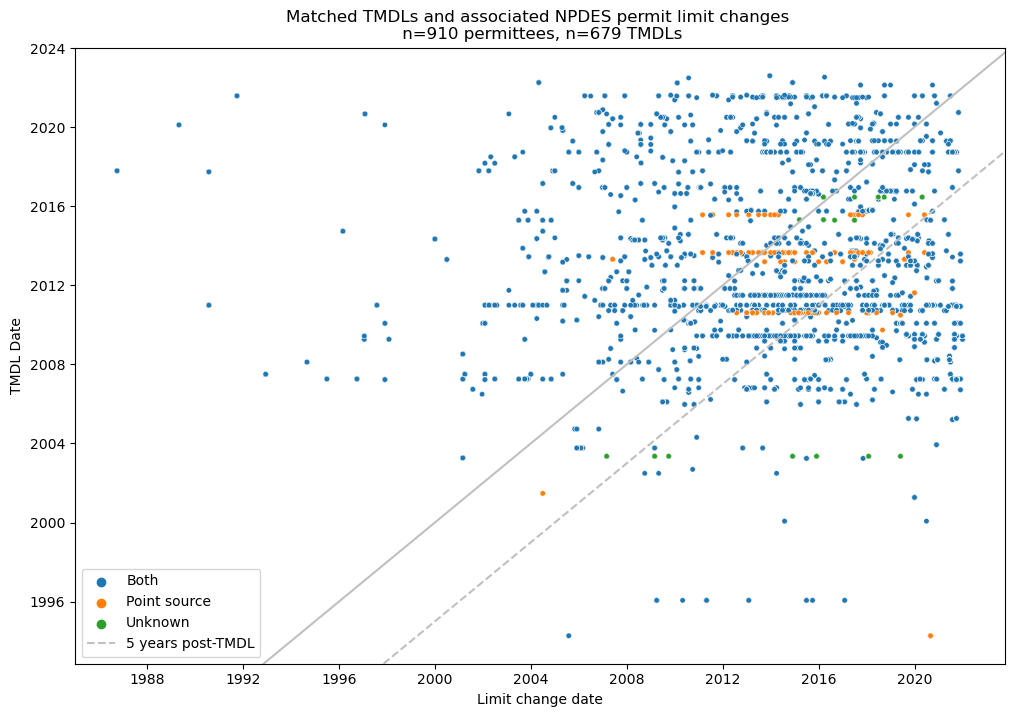

In [9]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('TMDL Date')
plt.xlabel('Limit change date')
sns.scatterplot(data=prepped_dmrs, x='limit_change_date', y='TMDLDate', hue='pollutantSourceTypeCode', s=15);
plt.axline((dts.datestr2num('2012-01-01'), dts.datestr2num('2012-01-01')),
           (dts.datestr2num('2012-01-02'), dts.datestr2num('2012-01-02')), color='silver')
plt.axline((dts.datestr2num('2017-01-01'), dts.datestr2num('2012-01-01')),
           (dts.datestr2num('2017-01-02'), dts.datestr2num('2012-01-02')), linestyle='--', label='5 years post-TMDL',
           color='silver')
plt.title('Matched TMDLs and associated NPDES permit limit changes \n n=' + str(
    len(prepped_dmrs.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(prepped_dmrs.drop_duplicates('actionIdentifier'))) + ' TMDLs');
plt.legend();